# GRU Model with AutoEncoder

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, LSTM, Dense, Input, Dropout, BatchNormalization, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
train_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_x.csv')
train_y = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/train_y.csv')
test_x = pd.read_csv('/Users/mohanyang/Documents/GitHub/SUROP_time_series/SUROP/data/test_x.csv')

In [3]:
# Display the first few rows
print(train_x.head())
print(train_x.shape)

   Hour  ID    Age  Gender  Unit1  Unit2     HR   O2Sat   Temp     SBP  ...  \
0     1   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
1     2   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
2     3   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
3     4   2  66.67     1.0    0.0    1.0  74.78  100.06  35.61  121.68  ...   
4     5   2  66.67     1.0    0.0    1.0  84.42   99.58  35.61  114.60  ...   

   Phosphate  Potassium  Bilirubin_total  TroponinI    Hct   Hgb  PTT   WBC  \
0        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
1        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
2        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
3        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   
4        NaN       4.48              NaN        NaN  28.83  9.21  NaN  8.15   

   Fibrinogen  Platelets  
0         NaN        Na

In [4]:
print(train_y.head())
print(train_y.shape)

   ID  Outcome
0   2        0
1   3        0
2   5        1
3   6        0
4  13        0
(12115, 2)


In [5]:
max_hours = train_x.groupby('ID')['Hour'].count().max()
print(f'Maximum number of hours: {max_hours}')

Maximum number of hours: 336


In [6]:
# Get unique person IDs
person_ids = train_x['ID'].unique()

# Initialize tensors for features, masks, and time intervals
num_persons = len(person_ids)
num_features = train_x.shape[1] - 2  # excluding 'ID' and 'Hour' columns

In [7]:
person_ids

array([    2,     3,     5, ..., 21630, 21632, 21633])

In [8]:
#Initialize tensors
X_tensor = np.zeros((num_persons, max_hours, num_features+1))

In [9]:
for i, person_id in enumerate(person_ids):
    person_data = train_x[train_x['ID'] == person_id].sort_values('Hour')
    hours = person_data['Hour'].values
    features = person_data.drop(columns=['ID']).values
    
    # Fill X_tensor
    X_tensor[i, :len(hours), :] = features

In [10]:
X_tensor

array([[[  1.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  2.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        [  3.  ,  66.67,   1.  , ...,   8.15,    nan,    nan],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  2.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        [  3.  ,  79.74,   0.  , ...,   6.82, 267.01, 281.18],
        ...,
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
        [  0.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ]],

       [[  1.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  2.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        [  3.  ,  60.74,   1.  , ...,  12.45,    nan,  84.77],
        ...,
        [  0

In [11]:
print(X_tensor.shape)

(12115, 336, 39)


In [12]:
# Ensure train_y is aligned with X_tensor
labels = np.zeros(len(person_ids))

for i, person_id in enumerate(person_ids):
    if person_id in train_y['ID'].values:
        labels[i] = train_y[train_y['ID'] == person_id]['Outcome'].values[0]

print(labels.shape)

(12115,)


In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, labels, test_size=0.2, random_state=10
)

In [14]:
def build_rdae(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    encoded = LSTM(128, activation='relu')(inputs)
    encoded = RepeatVector(input_shape[0])(encoded)
    
    # Decoder
    decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
    
    # Define the model
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [15]:
input_shape = (X_train.shape[1], X_train.shape[2])
rdae = build_rdae(input_shape)

In [16]:
#data with missing values replaced by zero
X_train_filled = np.nan_to_num(X_train)

# Normalize the data to be between 0 and 1
X_train_filled = (X_train_filled - np.min(X_train_filled)) / (np.max(X_train_filled) - np.min(X_train_filled))

In [17]:
# Train the autoencoder
optimizer = Adam()
rdae.compile(optimizer = optimizer, loss='mae')
rdae.fit(X_train_filled, X_train_filled, epochs=20, batch_size=64, validation_split=0.1)

# Use the trained autoencoder to impute missing values
X_train_rdae_imputed = rdae.predict(X_train_filled)

Epoch 1/20


  1/137 ━━━━━━━━━━━━━━━━━━━━ 11:39 5s/step - loss: 0.0287

  2/137 ━━━━━━━━━━━━━━━━━━━━ 1:10 523ms/step - loss: 0.0278

  3/137 ━━━━━━━━━━━━━━━━━━━━ 1:07 505ms/step - loss: 0.0269

  4/137 ━━━━━━━━━━━━━━━━━━━━ 1:06 501ms/step - loss: 0.0259

  5/137 ━━━━━━━━━━━━━━━━━━━━ 1:05 498ms/step - loss: 0.0249

  6/137 ━━━━━━━━━━━━━━━━━━━━ 1:06 505ms/step - loss: 0.0240

  7/137 ━━━━━━━━━━━━━━━━━━━━ 1:07 523ms/step - loss: 0.0231

  8/137 ━━━━━━━━━━━━━━━━━━━━ 1:09 541ms/step - loss: 0.0223

  9/137 ━━━━━━━━━━━━━━━━━━━━ 1:11 556ms/step - loss: 0.0216

 10/137 ━━━━━━━━━━━━━━━━━━━━ 1:11 567ms/step - loss: 0.0210

 11/137 ━━━━━━━━━━━━━━━━━━━━ 1:12 578ms/step - loss: 0.0203

 12/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 585ms/step - loss: 0.0197

 13/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 593ms/step - loss: 0.0192

 14/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 599ms/step - loss: 0.0187

 15/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 606ms/step - loss: 0.0182

 16/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 610ms/step - loss: 0.0177

 17/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 615ms/step - loss: 0.0173

 18/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 619ms/step - loss: 0.0169

 19/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 623ms/step - loss: 0.0165

 20/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 628ms/step - loss: 0.0162

 21/137 ━━━━━━━━━━━━━━━━━━━━ 1:13 630ms/step - loss: 0.0158

 22/137 ━━━━━━━━━━━━━━━━━━━━ 1:12 632ms/step - loss: 0.0155

 23/137 ━━━━━━━━━━━━━━━━━━━━ 1:12 634ms/step - loss: 0.0152

 24/137 ━━━━━━━━━━━━━━━━━━━━ 1:12 638ms/step - loss: 0.0149

 25/137 ━━━━━━━━━━━━━━━━━━━━ 1:11 641ms/step - loss: 0.0146

 26/137 ━━━━━━━━━━━━━━━━━━━━ 1:11 641ms/step - loss: 0.0144

 27/137 ━━━━━━━━━━━━━━━━━━━━ 1:10 642ms/step - loss: 0.0141

 28/137 ━━━━━━━━━━━━━━━━━━━━ 1:10 643ms/step - loss: 0.0139

 29/137 ━━━━━━━━━━━━━━━━━━━━ 1:09 645ms/step - loss: 0.0137

 30/137 ━━━━━━━━━━━━━━━━━━━━ 1:09 646ms/step - loss: 0.0134

 31/137 ━━━━━━━━━━━━━━━━━━━━ 1:08 650ms/step - loss: 0.0132

 32/137 ━━━━━━━━━━━━━━━━━━━━ 1:08 654ms/step - loss: 0.0130

 33/137 ━━━━━━━━━━━━━━━━━━━━ 1:08 654ms/step - loss: 0.0128

 34/137 ━━━━━━━━━━━━━━━━━━━━ 1:07 654ms/step - loss: 0.0126

 35/137 ━━━━━━━━━━━━━━━━━━━━ 1:06 655ms/step - loss: 0.0124

 36/137 ━━━━━━━━━━━━━━━━━━━━ 1:06 657ms/step - loss: 0.0123

 37/137 ━━━━━━━━━━━━━━━━━━━━ 1:05 657ms/step - loss: 0.0121

 38/137 ━━━━━━━━━━━━━━━━━━━━ 1:05 657ms/step - loss: 0.0119

KeyboardInterrupt: 

In [ ]:
X_train_rdae_imputed

In [18]:
def create_gru_model(input_shape, learning_rate=0.001, dropout_rate=0.2, regularization_factor=0.001):
    x_input = Input(shape=input_shape)
    
    # GRU layers with dropout, batch normalization, and regularization
    gru_output = GRU(units=64, return_sequences=False, kernel_regularizer=l2(regularization_factor))(x_input)
    gru_output = BatchNormalization()(gru_output)
    gru_output = Dropout(dropout_rate)(gru_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid', kernel_regularizer=l2(regularization_factor))(gru_output)
    
    # Create model
    model = Model(inputs=x_input, outputs=output)
    
    # Create an Adam optimizer with a custom learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    
    return model

In [19]:
input_shape = (max_hours, num_features+1)
model_gru_rdae = create_gru_model(input_shape)

history = model_gru_rdae.fit(X_train_rdae_imputed, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - AUC: 0.4960 - loss: 0.5041 - val_AUC: 0.5000 - val_loss: 0.4160
Epoch 2/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - AUC: 0.4842 - loss: 0.4010 - val_AUC: 0.5000 - val_loss: 0.4151
Epoch 3/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - AUC: 0.4727 - loss: 0.4001 - val_AUC: 0.5000 - val_loss: 0.4141
Epoch 4/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 0.4960 - loss: 0.3902 - val_AUC: 0.5000 - val_loss: 0.4134
Epoch 5/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - AUC: 0.5041 - loss: 0.3865 - val_AUC: 0.5000 - val_loss: 0.4130
Epoch 6/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 0.4889 - loss: 0.4035 - val_AUC: 0.5000 - val_loss: 0.4152
Epoch 7/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - AUC: 0.4842 - loss: 0.4163 - val_AUC: 0.5000 - val_loss: 0.4172
Epoch 8/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - AUC: 0.4963 - loss: 0.3980 - val_AUC: 0.5000 - val_loss: 0.4128
Epoch 9/50
485/485 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
# Evaluate the model on the test set
test_loss, test_auc = model_gru_rdae.evaluate(X_test, y_test)
print(f'Test AUC: {test_auc}')

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5000 - loss: nan
Test AUC: 0.5


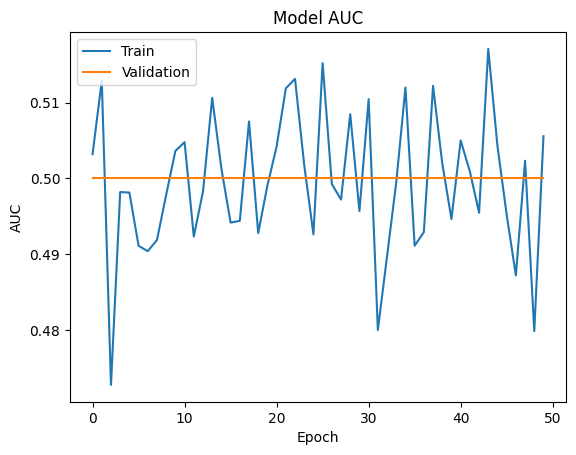

In [21]:
# Plot training & validation AUC values
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()